In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")
import math

In [167]:
## This file provides starter code for extracting features from the xml files and
## for doing some learning.
##
## The basic set-up: 
## ----------------
## main() will run code to extract features, learn, and make predictions.
## 
## extract_feats() is called by main(), and it will iterate through the 
## train/test directories and parse each xml file into an xml.etree.ElementTree, 
## which is a standard python object used to represent an xml file in memory.
## (More information about xml.etree.ElementTree objects can be found here:
## http://docs.python.org/2/library/xml.etree.elementtree.html
## and here: http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/)
## It will then use a series of "feature-functions" that you will write/modify
## in order to extract dictionaries of features from each ElementTree object.
## Finally, it will produce an N x D sparse design matrix containing the union
## of the features contained in the dictionaries produced by your "feature-functions."
## This matrix can then be plugged into your learning algorithm.
##
## The learning and prediction parts of main() are largely left to you, though
## it does contain code that randomly picks class-specific weights and predicts
## the class with the weights that give the highest score. If your prediction
## algorithm involves class-specific weights, you should, of course, learn 
## these class-specific weights in a more intelligent way.
##
## Feature-functions:
## --------------------
## "feature-functions" are functions that take an ElementTree object representing
## an xml file (which contains, among other things, the sequence of system calls a
## piece of potential malware has made), and returns a dictionary mapping feature names to 
## their respective numeric values. 
## For instance, a simple feature-function might map a system call history to the
## dictionary {'first_call-load_image': 1}. This is a boolean feature indicating
## whether the first system call made by the executable was 'load_image'. 
## Real-valued or count-based features can of course also be defined in this way. 
## Because this feature-function will be run over ElementTree objects for each 
## software execution history instance, we will have the (different)
## feature values of this feature for each history, and these values will make up 
## one of the columns in our final design matrix.
## Of course, multiple features can be defined within a single dictionary, and in
## the end all the dictionaries returned by feature functions (for a particular
## training example) will be unioned, so we can collect all the feature values 
## associated with that particular instance.
##
## Two example feature-functions, first_last_system_call_feats() and 
## system_call_count_feats(), are defined below.
## The first of these functions indicates what the first and last system-calls 
## made by an executable are, and the second records the total number of system
## calls made by an executable.
##
## What you need to do:
## --------------------
## 1. Write new feature-functions (or modify the example feature-functions) to
## extract useful features for this prediction task.
## 2. Implement an algorithm to learn from the design matrix produced, and to
## make predictions on unseen data. Naive code for these two steps is provided
## below, and marked by TODOs.
##
## Computational Caveat
## --------------------
## Because the biggest of any of the xml files is only around 35MB, the code below 
## will parse an entire xml file and store it in memory, compute features, and
## then get rid of it before parsing the next one. Storing the biggest of the files 
## in memory should require at most 200MB or so, which should be no problem for
## reasonably modern laptops. If this is too much, however, you can lower the
## memory requirement by using ElementTree.iterparse(), which does parsing in
## a streaming way. See http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/
## for an example. 

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util


def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
#     syscall_to_class = {}
#     NUM_FEATS_SYSCALL_LIMIT = 12
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
#             print clazz
#             print classes
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        #Roger
        #print clazz
        #print rowfd.keys()
#         if len(rowfd.keys()) > 0:
#             print clazz
        #TODO(rzou): iterate thru keys. See if any keys (syscalls) unique to particular clazz.
        # Have a dict of vals class_name or 1. Class_name is first class it's seen in. 1 is if mult classes.
#         for syscall in rowfd.keys():
#             if syscall not in syscall_to_class:
#                 syscall_to_class[syscall] = set([clazz])
#             elif syscall_to_class[syscall] == NUM_FEATS_SYSCALL_LIMIT:
#                 pass
#             elif clazz not in syscall_to_class[syscall]:
#                 if len(syscall_to_class[syscall]) == NUM_FEATS_SYSCALL_LIMIT - 1:
#                     syscall_to_class[syscall] = NUM_FEATS_SYSCALL_LIMIT
#                 else:
#                     syscall_to_class[syscall].add(clazz)

                
        fds.append(rowfd)
#     print syscall_to_class
#     for k,v in syscall_to_class.iteritems():
#         if v != NUM_FEATS_SYSCALL_LIMIT:
#             print k,v
#     print len(syscall_to_class) # num of keys
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
        
    cols = []
    rows = []
    data = []        
    for i in xrange(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].iteritems():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   

    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict
    

## Here are two example feature-functions. They each take an xml.etree.ElementTree object, 
# (i.e., the result of parsing an xml file) and returns a dictionary mapping 
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made. 
      (in other words, it returns a dictionary indicating what the first and 
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen
            
    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

# not sure if should prioritize counts or uniqueness? Or proportion? Unsure...
def specific_system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls-x' to the number of x-system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c["num_system_calls-"+el.tag] += 1 # Counter properly handles if not already in
            #c[el.tag] += 1 # for when looking for features
    return c

# checks for existence of canary syscalls. Training data showed the following are canaries:
# num_system_calls-vm_mapviewofsection Virut
# num_system_calls-enum_services Hupigon
# num_system_calls-logon_as_user FraudLoad
# num_system_calls-delete_share VB
# num_system_calls-set_system_time AutoRun
# num_system_calls-get_host_by_addr None
# num_system_calls-exit_windows None
# num_system_calls-create_process_nt None
# num_system_calls-get_userinfo None
# num_system_calls-com_createole_object None
# num_system_calls-enum_handles None
# num_system_calls-accept_socket None
# LOL FK I FORGOT I APPENDED THE num_system_calls- PREFIX FML
# Found canaries by iterating over all training data and looking for unique calls
# below: all functions that don't appear in every function. their absence can be a good indicator.
# load_driver set(['Magania', 'None', 'Hupigon', 'Krap', 'Agent'])
# get_host_by_addr set(['None'])
# create_interface set(['Zbot', 'None', 'Agent'])
# enum_items set(['None', 'Agent'])
# change_service_config set(['None', 'VB', 'Agent', 'Virut', 'Magania', 'Hupigon'])
# exit_windows set(['None'])
# enum_modules set(['FraudPack', 'VB', 'Tdss', 'FraudLoad', 'None', 'Agent', 'Zbot', 'Lipler', 'AutoRun', 'Hupigon', 'Krap'])
# enum_types set(['Zbot', 'None', 'Agent'])
# write_value set(['None', 'Agent', 'Lipler', 'Poison', 'AutoRun', 'Magania'])
# unload_driver set(['Magania', 'Krap', 'Agent'])
# message set(['VB', 'None', 'Agent', 'Swizzor'])
# get_userinfo set(['None'])
# create_service set(['None', 'Agent', 'Lipler', 'VB', 'Virut', 'Magania', 'Hupigon', 'Krap'])
# move_file set(['None', 'Lipler', 'Tdss', 'Swizzor', 'VB', 'Agent', 'Zbot', 'Virut', 'FraudLoad', 'Magania', 'Hupigon'])
# vm_write set(['VB', 'Lipler', 'Tdss', 'Swizzor', 'Agent', 'Poison', 'Zbot', 'Virut', 'AutoRun', 'None', 'Krap'])
# create_process_as_user set(['Zbot', 'Tdss'])
# create_mailslot set(['None', 'FraudLoad'])
# com_createole_object set(['None'])
# listen_socket set(['Zbot', 'VB', 'Hupigon', 'None', 'Agent'])
# enum_share set(['FraudPack', 'None', 'VB', 'Agent', 'Hupigon', 'Krap'])
# vm_mapviewofsection set(['Virut'])
# download_file set(['None', 'Swizzor', 'VB', 'Agent', 'Magania', 'Krap'])
# delete_share set(['VB'])
# logon_as_user set(['FraudLoad'])
# set_thread_context set(['None', 'Tdss', 'Agent', 'VB', 'Poison', 'Virut', 'AutoRun', 'Krap'])
# create_process_nt set(['None'])
# vm_allocate set(['VB', 'Lipler', 'Tdss', 'Swizzor', 'Agent', 'Poison', 'Zbot', 'Virut', 'AutoRun', 'None', 'Krap'])
# enum_handles set(['None'])
# start_service set(['None', 'Lipler', 'Tdss', 'VB', 'Agent', 'Virut', 'FraudLoad', 'Magania', 'Hupigon', 'Krap'])
# create_thread_remote set(['None', 'Lipler', 'Swizzor', 'VB', 'Agent', 'Zbot', 'Poison', 'AutoRun', 'Krap', 'Virut'])
# connect set(['FraudPack', 'None', 'Tdss', 'AutoRun', 'VB', 'Lipler', 'Zbot', 'Agent', 'FraudLoad', 'Krap'])
# enum_services set(['Hupigon'])
# vm_read set(['None', 'Agent', 'VB', 'Lipler', 'Virut', 'Krap'])
# delete_service set(['None', 'Hupigon', 'Agent'])
# read_section set(['None', 'Lipler'])
# set_system_time set(['AutoRun'])
# add_netjob set(['VB', 'None'])
# control_service set(['None', 'Tdss', 'Agent', 'FraudLoad', 'Magania', 'Hupigon'])
# accept_socket set(['None'])
# download_file_to_cache set(['None', 'Agent', 'Lipler'])
# revert_to_self set(['FraudPack', 'None', 'Tdss', 'Swizzor', 'VB', 'Agent', 'Zbot', 'FraudLoad', 'Krap'])
# enum_subtypes set(['None', 'Agent'])
# remove_directory set(['FraudPack', 'None', 'Lipler', 'Tdss', 'Swizzor', 'VB', 'Agent', 'Virut', 'Hupigon'])
# create_namedpipe set(['None', 'Tdss', 'Agent', 'Zbot', 'FraudLoad', 'Krap'])

def has_canary_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'canary-x' to 1 if a canary syscall was
      made by an executable
    """
    canaries = set([\
            "load_driver",
            "get_host_by_addr",
            "create_interface",
            "enum_items",
            "change_service_config",
            "exit_windows",
            "enum_modules",
            "enum_types",
            "write_value",
            "unload_driver",
            "message",
            "get_userinfo",
            "create_service",
            "move_file",
            "vm_write",
            "create_process_as_user",
            "create_mailslot",
            "com_createole_object",
            "listen_socket",
            "enum_share",
            "vm_mapviewofsection",
            "download_file",
            "delete_share",
            "logon_as_user",
            "set_thread_context",
            "create_process_nt",
            "vm_allocate",
            "enum_handles",
            "start_service",
            "create_thread_remote",
            "connect",
            "enum_services",
            "vm_read",
            "delete_service",
            "read_section",
            "set_system_time",
            "add_netjob",
            "control_service",
            "accept_socket",
            "download_file_to_cache",
            "revert_to_self",
            "enum_subtypes",
            "remove_directory",
            "create_namedpipe",                    
                    
                    
                    
#             "get_host_by_addr",
#             "create_interface",
#             "enum_items",
#             "exit_windows",
#             "enum_types",
#             "unload_driver",
#             "message",
#             "get_userinfo",
#             "create_process_as_user",
#             "create_mailslot",
#             "com_createole_object",
#             "vm_mapviewofsection",
#             "delete_share",
#             "logon_as_user",
#             "create_process_nt",
#             "enum_handles",
#             "enum_services",
#             "delete_service",
#             "read_section",
#             "set_system_time",
#             "add_netjob",
#             "accept_socket",
#             "download_file_to_cache",
#             "enum_subtypes",
                    
                    
#         'vm_mapviewofsection',
#         'enum_services',
#         'logon_as_user',
#         'delete_share',
#         'set_system_time',
#         'get_host_by_addr',
#         'exit_windows',
#         'create_process_nt',
#         'get_userinfo',
#         'com_createole_object',
#         'enum_handles',
#         'accept_socket',
    ])
    s = set()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section and el.tag in canaries:
            s.add('canary-' + el.tag)
    return dict.fromkeys(s, 1)
    
# IN WHICH YOU REALIZE THE STAFF-PROVIDED SKELETON CODE IS WRONG AHHHHHH
# 'Magania': 29, 'None': 7, 'Agent': 7. On training data. Really good! Out of maybe 41 Magania cases.
def magania_fonts_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'windows-fonts' to 1 if a open_file syscall used srcfile="C:\windows\fonts\*"
      made by an executable
    Roger note: probably magania?
    """
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section and el.tag == 'open_file':
#             print 'wtfmate open'
            key_string = el.get('srcfile')
#             print key_string
#             if key_string:
#                 print key_string
            if key_string and key_string[:17].lower() == 'c:\\windows\\fonts\\':
                return {'magania_fonts' : 1}
        else:
#             print el.tag, 'lol'
#             print el.tag, in_all_section
            if el.tag == 'open_file':
#                 print 'seriously wat'
#                 print in_all_section
                key_string = el.get('srcfile')
#                 print key_string
                if key_string and key_string[:17].lower() == 'c:\\windows\\fonts\\':
                    return {'magania_fonts' : 1}

    return {}    
    
def DO_NOT_USE_query_value_file_extensions_unique_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'extension-x' to 1 if a query_value syscall used key="*/.x"
      made by an executable
    Roger note: innocent extensions (.ppt, .txt) probably indicates more likely None
    """
    s = set()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section and el.tag == 'query_value':
            key_string = el.get('key')
            if key_string:
                last_backslash_index = key_string.rfind('\\') # because backslash is used to escape, there are two
                if last_backslash_index != -1 and key_string[last_backslash_index + 1] == '.':
                    # if the last thing after backslash is a dot extension, add the extension (w/o dot) to unique set as seen
                    # for why not checking membership first, see http://stackoverflow.com/questions/29928634/should-i-check-if-an-item-is-already-in-a-set-before-adding-it/29928674#29928674
                    s.add('extension-' + key_string[last_backslash_index + 2:])
    return dict.fromkeys(s, 1)

def query_value_has_dot_file_extensions_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'has_dot' to 1 if a query_value syscall used key="*/.x"
      made by an executable. Generally, tests (showitdammit.csv) show that if there is one, there will be many. Else, none.
    Roger note: innocent extensions (.ppt, .txt) probably indicates more likely None
    """
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section and el.tag == 'query_value':
            key_string = el.get('key')
            if key_string:
                last_backslash_index = key_string.rfind('\\') # because backslash is used to escape, there are two
                if last_backslash_index != -1 and key_string[last_backslash_index + 1] == '.':
                    # if the last thing after backslash is a dot extension, add the extension (w/o dot) to unique set as seen
                    # for why not checking membership first, see http://stackoverflow.com/questions/29928634/should-i-check-if-an-item-is-already-in-a-set-before-adding-it/29928674#29928674
                    return {'has_dot' : 1}
    return {} # empty dict

# vm_protect get target= key and use regex to get unique identifier string
# example: target=SHELL32.dll.&#x24;1FD852. Grab "SHELL32". Stuff after .dll. is sometimes useful, sometimes random stuff.
# Basically, if there's a .dll (dunno if need to check for this), grab the string before it
def vm_protect_targets_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'target-x' to 1 if a vm_protect syscall used target="*.dll.*"
      made by an executable
    Roger note: idk if will be effective
    """
    s = set()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section and el.tag == 'vm_protect':
            key_string = el.get('target')
            if key_string:
                first_dll_index = key_string.find('.dll') # find first
                if first_dll_index != -1:
                    # if the last thing after backslash is a dot extension, add the extension (w/o dot) to unique set as seen
                    # for why not checking membership first, see http://stackoverflow.com/questions/29928634/should-i-check-if-an-item-is-already-in-a-set-before-adding-it/29928674#29928674
                    s.add('vm_targets-' + key_string[:first_dll_index])
    return dict.fromkeys(s, 1)

    
## The following function does the feature extraction, learning, and prediction
def main():
    train_dir = "train"
    test_dir = "test"
    outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument
    
    # TODO put the names of the feature functions you've defined above in this list
    ffs = [first_last_system_call_feats, system_call_count_feats]
    
    # extract features
    print "extracting training features..."
    X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
    print "done extracting training features"
    print
    
    # TODO train here, and learn your classification parameters
    print "learning..."
    learned_W = np.random.random((len(global_feat_dict),len(util.malware_classes)))
    print "done learning"
    print
    
    # get rid of training data and load test data
    del X_train
    del t_train
    del train_ids
    print "extracting test features..."
    X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
    print "done extracting test features"
    print
    
    # TODO make predictions on text data and write them out
    print "making predictions..."
    preds = np.argmax(X_test.dot(learned_W),axis=1)
    print "done making predictions"
    print
    
    print "writing predictions..."
    util.write_predictions(preds, test_ids, outputfile)
    print "done!"
    

In [166]:
train_dir = "train"
#train_dir = "train_small" # FOR TESTING
#train_dir = "magania"
#train_dir = "wtfmate"
test_dir = "test"
outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument

# TODO put the names of the feature functions you've defined above in this list
ffs = [#first_last_system_call_feats, system_call_count_feats,\
        #specific_system_call_count_feats,\
        #query_value_has_dot_file_extensions_feats,\
        #vm_protect_targets_feats,\
        #has_canary_system_call_feats,\
        magania_fonts_feats,\
        ]

# extract features
print "extracting training features..."
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
print "done extracting training features"

extracting training features...
Agent
Magania
Magania
Magania
Agent
None
Magania
Magania
Agent
Magania
Magania
Magania
Magania
Magania
Magania
Magania
Agent
Magania
Magania
Magania
None
Magania
Magania
Agent
Magania
Magania
None
Magania
Magania
Magania
None
Magania
Magania
None
Magania
Magania
Magania
None
Magania
Agent
Agent
Magania
None
done extracting training features


In [168]:
X_train.shape

(3086, 1)

### Feature Engineering TODO Roger to add your input

In [169]:
#print sum(X_train)
print X_train

  (31, 0)	1
  (33, 0)	1
  (186, 0)	1
  (241, 0)	1
  (311, 0)	1
  (355, 0)	1
  (424, 0)	1
  (435, 0)	1
  (496, 0)	1
  (600, 0)	1
  (624, 0)	1
  (635, 0)	1
  (649, 0)	1
  (674, 0)	1
  (946, 0)	1
  (1012, 0)	1
  (1022, 0)	1
  (1027, 0)	1
  (1032, 0)	1
  (1312, 0)	1
  (1328, 0)	1
  (1339, 0)	1
  (1613, 0)	1
  (1618, 0)	1
  (1807, 0)	1
  (1858, 0)	1
  (1875, 0)	1
  (2092, 0)	1
  (2124, 0)	1
  (2210, 0)	1
  (2381, 0)	1
  (2480, 0)	1
  (2507, 0)	1
  (2584, 0)	1
  (2688, 0)	1
  (2722, 0)	1
  (2725, 0)	1
  (2743, 0)	1
  (2847, 0)	1
  (2893, 0)	1
  (2955, 0)	1
  (2970, 0)	1
  (3026, 0)	1


In [45]:
pd.DataFrame(X_train.todense())#.to_csv('showitdammit.csv')

### Approaches
#### Random Forest

In [100]:
RF = RandomForestClassifier()
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy")

Random Forest Classifier
[ 0.78685897  0.77419355  0.79058442  0.78211382  0.78559738]


#### Multinomial Bayes

In [99]:
from sklearn.naive_bayes import MultinomialNB
MNNB = MultinomialNB()
print "Multinomial NB"
print cross_val_score(MNNB, X_train, t_train, cv=5, scoring="accuracy")

Multinomial NB
[ 0.60737179  0.64193548  0.63311688  0.63739837  0.6710311 ]


In [47]:
MNNB.fit(X_train, t_train)
predictions = MNNB.predict(X_train)

In [48]:
def get_prediction_accuracy(predictions, t_train):
    in_both = [i for i, j in zip(predictions, t_train) if i == j]
    print len(in_both) / float(len(predictions))

#### SVM

In [101]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, t_train)
print "SVM Classifier"
print cross_val_score(lin_clf, X_train, t_train, cv=5, scoring="accuracy")

SVM Classifier
[ 0.52884615  0.18064516  0.27272727  0.55121951  0.04255319]


### Data Exploration

In [86]:
df['class'].describe()

count    3086.000000
mean        8.378483
std         2.795222
min         0.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        14.000000
Name: class, dtype: float64

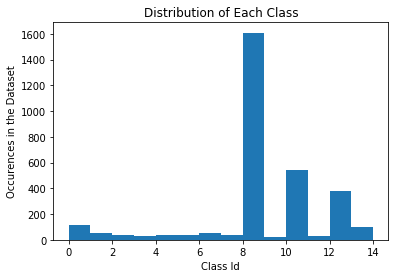

In [89]:
%matplotlib inline
plt.hist(df['class'], bins=14)
plt.title("Distribution of Each Class")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

### 2 layer TODO BRIAN

In [97]:
df = pd.DataFrame(X_train.toarray())
df['class'] = t_train
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,class
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,643,8
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5422,6
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,93,12
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,430,8
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1085,10


In [77]:
len(none)

114

In [ ]:
### 

#### Outputting predictions

In [92]:
print "extracting test features..."
X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
print "done extracting test features"

extracting test features...
done extracting test features


In [93]:
RF_preds = RF.predict(X_test)
print "writing predictions..."
util.write_predictions(RF_preds, test_ids, "rfpredictions.csv")

writing predictions...


In [94]:
MNNB_preds = MNNB.predict(X_test)
print "writing predictions..."
util.write_predictions(MNNB_preds, test_ids, "mnnbpredictions.csv")

writing predictions...


In [96]:
lin_clf_preds = lin_clf.predict(X_test)
print "writing predictions..."
util.write_predictions(lin_clf_preds, test_ids, "svmpredictions.csv")

writing predictions...
